# Data Quality & Validation 
## A Hands-On Guide for Data Engineers and Analysts

Welcome to our comprehensive workshop on Data Quality & Validation! As a Senior Data Engineer, I'll guide you through the critical aspects of ensuring data integrity in real-world scenarios.

### 🎯 Workshop Objectives:
- Understand the fundamental importance of data quality
- Learn practical validation techniques using Python & Pandas
- Master SQL-based validation approaches
- Solve real-world data quality challenges
- Build automated quality assessment frameworks

### 📊 Why Data Quality Matters:
Poor data quality costs organizations an average of **$15 million annually**. In this workshop, you'll learn to:
- Identify and fix data quality issues before they impact business decisions
- Build confidence in your analytics and reporting
- Prevent costly mistakes in customer segmentation and targeting
- Establish data quality standards for your organization

**Let's dive in!** 🚀

## 1. Import Required Libraries and Setup

Before we start our data quality journey, let's import all the necessary libraries and configure our environment for optimal analysis.

In [1]:
# Essential libraries for data quality validation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Tuple

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")
print("🚀 Ready to begin data quality validation!")

✅ All libraries imported successfully!
📊 Pandas version: 2.3.1
🔢 NumPy version: 2.2.6
🚀 Ready to begin data quality validation!


## 2. Create Mock E-commerce Dataset

Let's create realistic e-commerce datasets with intentional data quality issues. This will help us practice identifying and fixing common problems you'll encounter in real-world scenarios.

In [2]:
# Set random seed for reproducible results
np.random.seed(42)

# Generate customer data with intentional quality issues
def create_customer_data(n_customers=1000):
    """Create mock customer dataset with data quality issues"""
    
    # Generate base customer data
    customer_ids = range(1, n_customers + 1)
    
    # Names with some missing values
    first_names = ['John', 'Jane', 'Mike', 'Sarah', 'David', 'Lisa', 'Chris', 'Emma', 
                   'Alex', 'Sophie', 'Mark', 'Anna', 'Tom', 'Julia', 'Sam']
    last_names = ['Smith', 'Johnson', 'Brown', 'Davis', 'Wilson', 'Moore', 'Taylor', 
                  'Anderson', 'Thomas', 'Jackson', 'White', 'Harris', 'Martin', 'Garcia']
    
    names = []
    for i in range(n_customers):
        if np.random.random() < 0.05:  # 5% missing names
            names.append(None)
        else:
            first = np.random.choice(first_names)
            last = np.random.choice(last_names)
            names.append(f"{first} {last}")
    
    # Email addresses with format issues
    emails = []
    for i, name in enumerate(names):
        if name is None:
            emails.append(None)
        elif np.random.random() < 0.08:  # 8% invalid email formats
            # Create intentionally bad emails
            bad_emails = [
                f"{name.lower().replace(' ', '.')}@",  # Missing domain
                f"{name.lower().replace(' ', '.')}gmail.com",  # Missing @
                f"@{name.lower().replace(' ', '.')}.com",  # Missing username
                f"{name.lower().replace(' ', '.')}@.com",  # Missing domain name
            ]
            emails.append(np.random.choice(bad_emails))
        else:
            # Create valid emails
            domains = ['gmail.com', 'yahoo.com', 'hotmail.com', 'outlook.com', 'company.com']
            email = f"{name.lower().replace(' ', '.')}@{np.random.choice(domains)}"
            emails.append(email)
    
    # Age with outliers and missing values
    ages = []
    for i in range(n_customers):
        if np.random.random() < 0.03:  # 3% missing ages
            ages.append(None)
        elif np.random.random() < 0.02:  # 2% unrealistic ages
            ages.append(np.random.choice([150, 200, -5, 0]))  # Outliers
        else:
            ages.append(np.random.normal(35, 12))  # Normal distribution
    
    # Registration dates
    start_date = datetime(2020, 1, 1)
    end_date = datetime(2024, 10, 1)
    reg_dates = []
    for i in range(n_customers):
        if np.random.random() < 0.02:  # 2% missing registration dates
            reg_dates.append(None)
        else:
            random_date = start_date + timedelta(
                days=np.random.randint(0, (end_date - start_date).days)
            )
            reg_dates.append(random_date)
    
    # Last purchase dates (some customers never purchased)
    last_purchase_dates = []
    for i, reg_date in enumerate(reg_dates):
        if reg_date is None:
            last_purchase_dates.append(None)
        elif np.random.random() < 0.15:  # 15% never purchased
            last_purchase_dates.append(None)
        else:
            # Last purchase after registration
            days_since_reg = (datetime.now() - reg_date).days
            purchase_date = reg_date + timedelta(
                days=np.random.randint(1, min(days_since_reg + 1, 365))
            )
            last_purchase_dates.append(purchase_date)
    
    # Total spent with outliers
    total_spent = []
    for i, last_purchase in enumerate(last_purchase_dates):
        if last_purchase is None:  # Never purchased
            total_spent.append(0.0)
        elif np.random.random() < 0.01:  # 1% extreme outliers
            total_spent.append(np.random.choice([50000, 75000, 100000]))
        else:
            # Log-normal distribution for realistic spending
            spent = np.random.lognormal(mean=4, sigma=1.5)
            total_spent.append(round(spent, 2))
    
    # Create DataFrame
    customers_df = pd.DataFrame({
        'customer_id': customer_ids,
        'name': names,
        'email': emails,
        'age': ages,
        'registration_date': reg_dates,
        'last_purchase_date': last_purchase_dates,
        'total_spent': total_spent
    })
    
    # Add some duplicate records (exact duplicates)
    duplicate_indices = np.random.choice(customers_df.index, size=20, replace=False)
    duplicate_rows = customers_df.loc[duplicate_indices].copy()
    customers_df = pd.concat([customers_df, duplicate_rows], ignore_index=True)
    
    return customers_df

# Generate orders data
def create_orders_data(customers_df, n_orders=3000):
    """Create mock orders dataset with referential integrity issues"""
    
    # Get valid customer IDs (excluding duplicates and missing data)
    valid_customer_ids = customers_df['customer_id'].dropna().unique()
    
    order_data = []
    for i in range(1, n_orders + 1):
        # 95% valid customer IDs, 5% orphaned records
        if np.random.random() < 0.05:
            customer_id = np.random.randint(10000, 20000)  # Non-existent customer
        else:
            customer_id = np.random.choice(valid_customer_ids)
        
        # Order date
        order_date = datetime(2020, 1, 1) + timedelta(
            days=np.random.randint(0, (datetime(2024, 10, 1) - datetime(2020, 1, 1)).days)
        )
        
        # Order value with outliers
        if np.random.random() < 0.02:  # 2% extreme outliers
            order_value = np.random.choice([10000, 15000, 20000])
        else:
            order_value = np.random.lognormal(mean=3, sigma=1)
        
        order_data.append({
            'order_id': i,
            'customer_id': customer_id,
            'order_date': order_date,
            'order_value': round(order_value, 2)
        })
    
    return pd.DataFrame(order_data)

# Create our datasets
print("🏗️ Creating mock e-commerce datasets...")
customers_df = create_customer_data(1000)
orders_df = create_orders_data(customers_df, 3000)

print(f"✅ Customer dataset created: {len(customers_df)} records")
print(f"✅ Orders dataset created: {len(orders_df)} records")
print("\n📋 Customer Data Preview:")
print(customers_df.head())
print("\n📋 Orders Data Preview:")
print(orders_df.head())

🏗️ Creating mock e-commerce datasets...
✅ Customer dataset created: 1020 records
✅ Orders dataset created: 3000 records

📋 Customer Data Preview:
   customer_id          name                    email        age  \
0            1     Tom White      tom.white@gmail.com  45.202464   
1            2  David Taylor   david.taylor@yahoo.com  29.546469   
2            3   Chris White  chris.white@company.com  34.095445   
3            4   David Davis    david.davis@gmail.com  43.415508   
4            5    Mike Moore     mike.moore@yahoo.com  24.437358   

  registration_date last_purchase_date  total_spent  
0        2023-08-26         2024-04-27        33.88  
1        2023-02-01         2023-09-20       134.44  
2               NaT                NaT         0.00  
3        2023-12-08         2024-05-31        87.41  
4        2020-09-09         2021-07-17         5.89  

📋 Orders Data Preview:
   order_id  customer_id order_date  order_value
0         1          308 2023-03-15        50.25

## 3. Data Quality Dimensions Overview

Understanding the fundamental dimensions of data quality is crucial for any data professional. Let's explore the **6 core dimensions** with practical examples from our dataset:

### 🎯 The 6 Dimensions of Data Quality:

1. **Completeness**: Are all required data points present?
2. **Accuracy**: Does the data correctly represent reality?
3. **Uniqueness**: Are there unwanted duplicate records?
4. **Validity**: Does the data conform to defined formats/rules?
5. **Consistency**: Is the data uniform across different sources?
6. **Timeliness**: Is the data current and up-to-date?

Each dimension directly impacts business decisions. Poor data quality in customer segmentation, for example, can lead to:
- ❌ Incorrect marketing targeting
- ❌ Revenue loss from missed opportunities  
- ❌ Damaged customer relationships
- ❌ Compliance and regulatory issues

In [3]:
# Quick overview of our dataset's data quality issues
def data_quality_overview(df, df_name):
    """Provide a high-level overview of data quality issues"""
    print(f"\n📊 {df_name} Dataset Overview:")
    print("=" * 50)
    print(f"📏 Total Records: {len(df):,}")
    print(f"🏛️ Total Columns: {len(df.columns)}")
    print(f"💾 Memory Usage: {df.memory_usage(deep=True).sum() / 1024:.1f} KB")
    
    # Missing values summary
    missing_count = df.isnull().sum().sum()
    missing_percent = (missing_count / (len(df) * len(df.columns))) * 100
    print(f"❓ Missing Values: {missing_count:,} ({missing_percent:.1f}%)")
    
    # Duplicate rows
    duplicate_count = df.duplicated().sum()
    print(f"🔄 Duplicate Rows: {duplicate_count:,}")
    
    print("\n🔍 Column-by-Column Analysis:")
    for col in df.columns:
        missing = df[col].isnull().sum()
        missing_pct = (missing / len(df)) * 100
        unique_vals = df[col].nunique()
        data_type = df[col].dtype
        print(f"  • {col}: {missing:,} missing ({missing_pct:.1f}%) | {unique_vals:,} unique | {data_type}")

# Analyze both datasets
data_quality_overview(customers_df, "Customers")
data_quality_overview(orders_df, "Orders")


📊 Customers Dataset Overview:
📏 Total Records: 1,020
🏛️ Total Columns: 7
💾 Memory Usage: 184.2 KB
❓ Missing Values: 331 (4.6%)
🔄 Duplicate Rows: 20

🔍 Column-by-Column Analysis:
  • customer_id: 0 missing (0.0%) | 1,000 unique | int64
  • name: 53 missing (5.2%) | 207 unique | object
  • email: 53 missing (5.2%) | 669 unique | object
  • age: 33 missing (3.2%) | 956 unique | float64
  • registration_date: 26 missing (2.5%) | 743 unique | datetime64[ns]
  • last_purchase_date: 166 missing (16.3%) | 653 unique | datetime64[ns]
  • total_spent: 0 missing (0.0%) | 816 unique | float64

📊 Orders Dataset Overview:
📏 Total Records: 3,000
🏛️ Total Columns: 4
💾 Memory Usage: 93.9 KB
❓ Missing Values: 0 (0.0%)
🔄 Duplicate Rows: 0

🔍 Column-by-Column Analysis:
  • order_id: 0 missing (0.0%) | 3,000 unique | int64
  • customer_id: 0 missing (0.0%) | 1,086 unique | int64
  • order_date: 0 missing (0.0%) | 1,429 unique | datetime64[ns]
  • order_value: 0 missing (0.0%) | 2,289 unique | float64


## 4. Missing Values Detection and Analysis

**Missing values** are one of the most common data quality issues. They can occur due to:
- System failures during data collection
- User input errors or omissions  
- Data integration problems
- Privacy restrictions

### 🔍 Why Missing Values Matter:
- Can skew statistical analysis and ML models
- Lead to biased business insights
- Reduce the reliability of reports
- Impact customer experience (e.g., incomplete profiles)

Let's systematically detect and analyze missing values in our dataset.


🔍 Missing Values Analysis - Customers
📊 Missing Values Summary:
               Column  Missing_Count  Missing_Percentage       Data_Type  \
5  last_purchase_date            166               16.27  datetime64[ns]   
1                name             53                5.20          object   
2               email             53                5.20          object   
3                 age             33                3.24         float64   
4   registration_date             26                2.55  datetime64[ns]   
0         customer_id              0                0.00           int64   
6         total_spent              0                0.00         float64   

   Non_Null_Count  
5             854  
1             967  
2             967  
3             987  
4             994  
0            1020  
6            1020  


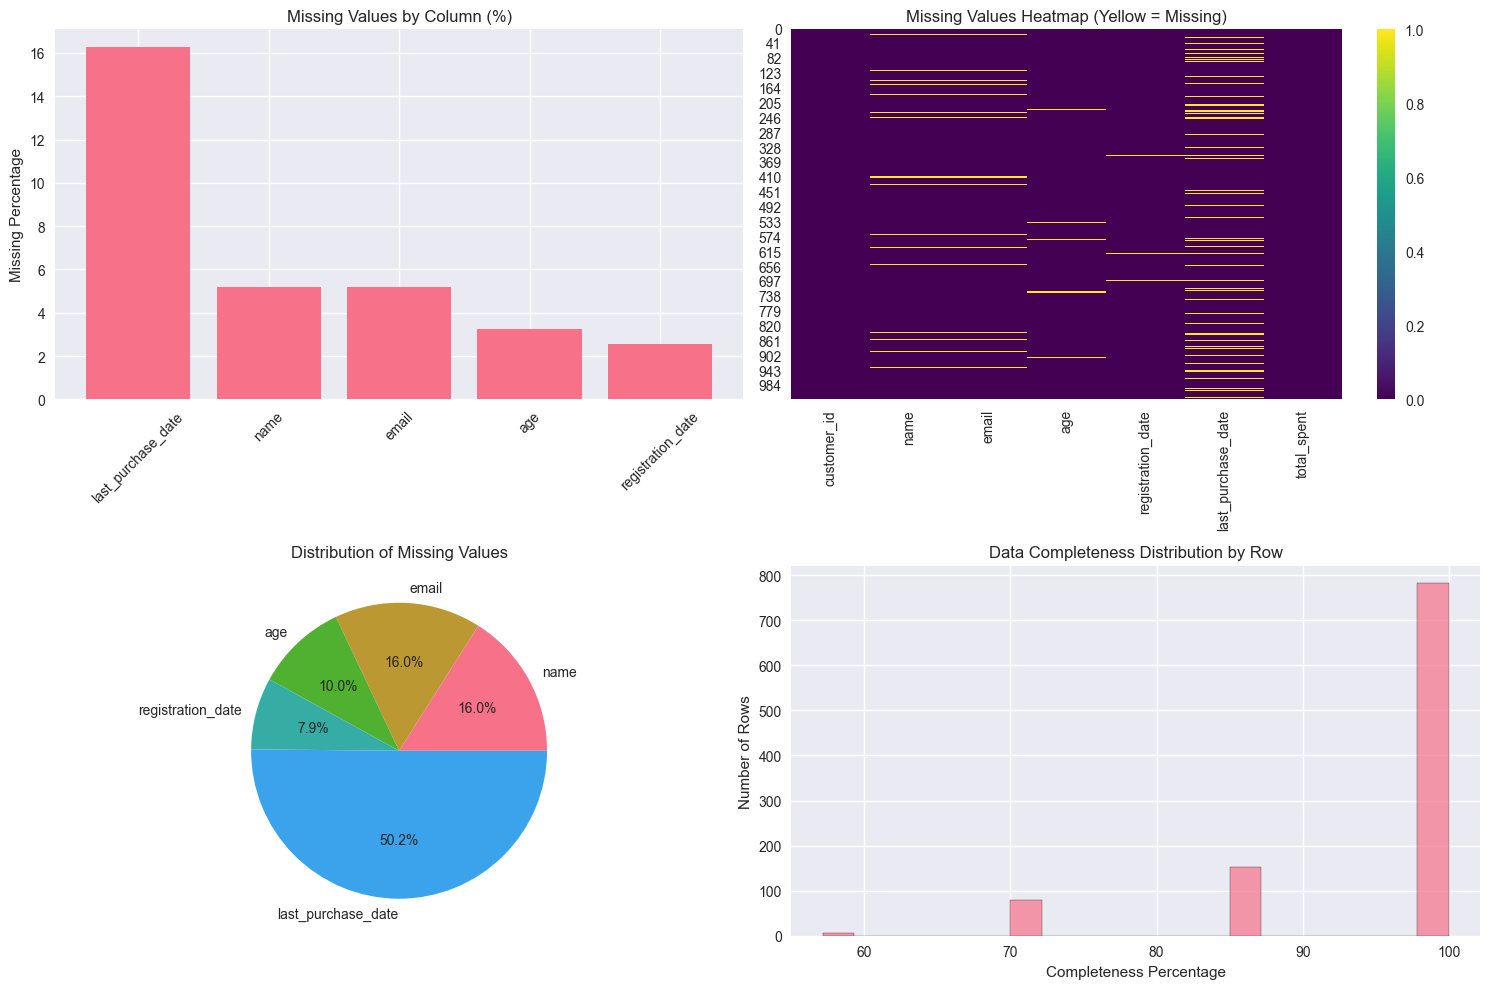


🔍 Missing Value Patterns:
  • 782 rows with no missing values
  • 128 rows missing: last_purchase_date
  • 48 rows missing: name, email
  • 24 rows missing: registration_date, last_purchase_date
  • 24 rows missing: age
  • 7 rows missing: age, last_purchase_date
  • 5 rows missing: name, email, last_purchase_date
  • 2 rows missing: age, registration_date, last_purchase_date

🔍 Missing Values Analysis - Orders
📊 Missing Values Summary:
        Column  Missing_Count  Missing_Percentage       Data_Type  \
0     order_id              0                 0.0           int64   
1  customer_id              0                 0.0           int64   
2   order_date              0                 0.0  datetime64[ns]   
3  order_value              0                 0.0         float64   

   Non_Null_Count  
0            3000  
1            3000  
2            3000  
3            3000  


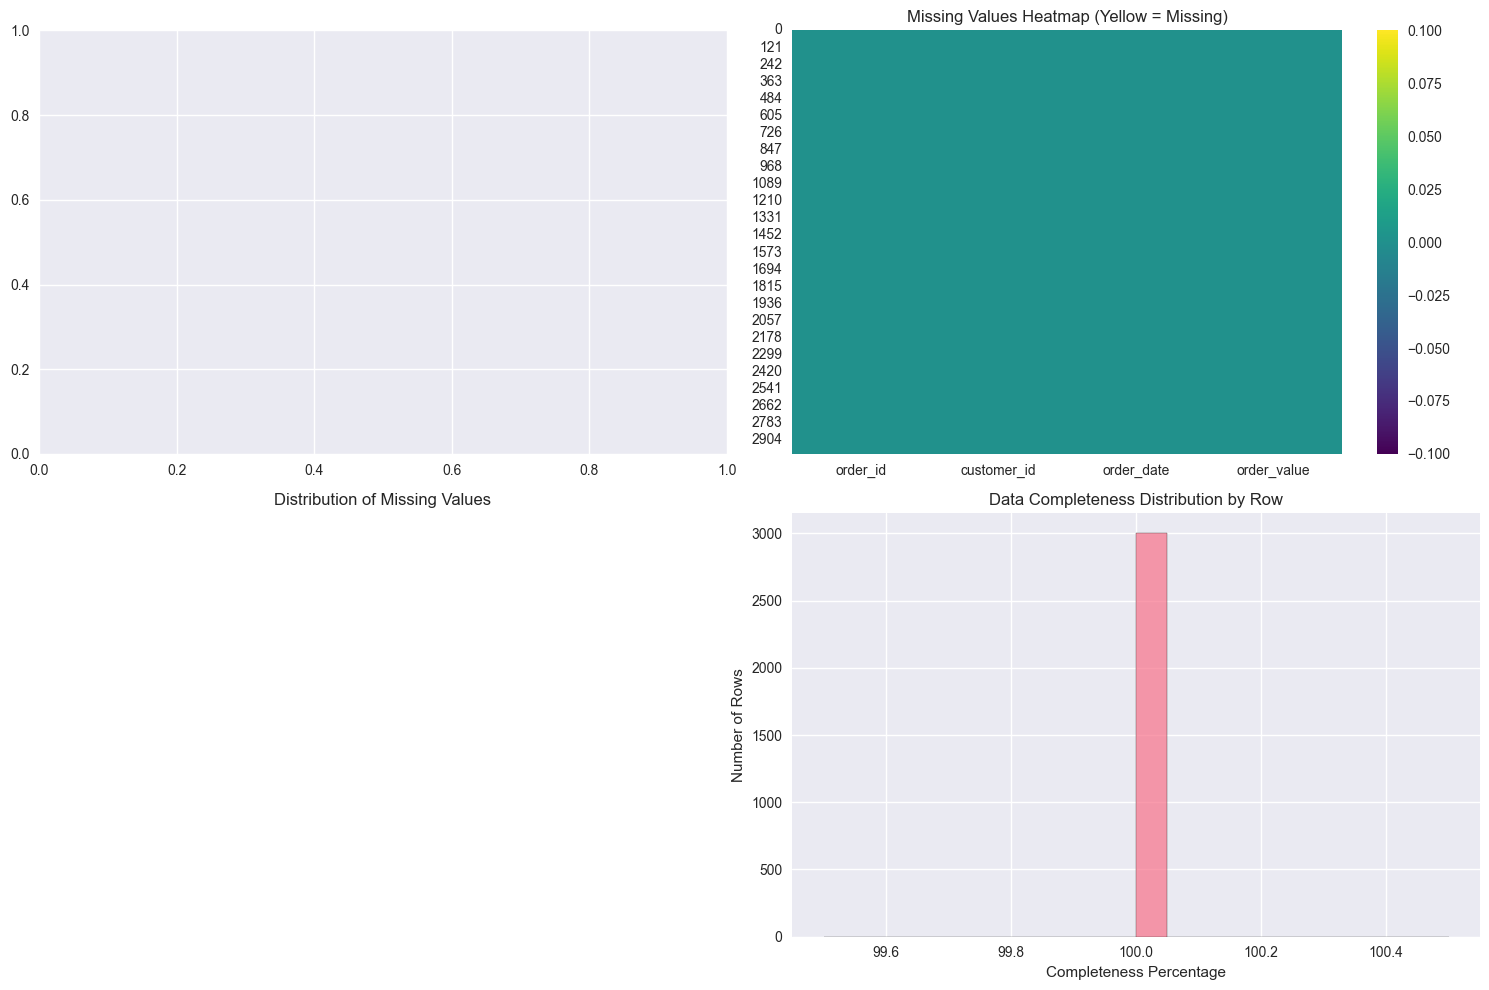


🔍 Missing Value Patterns:
  • 3,000 rows with no missing values


In [4]:
# Comprehensive missing values analysis
def analyze_missing_values(df, df_name):
    """Detailed analysis of missing values with visualizations"""
    
    print(f"\n🔍 Missing Values Analysis - {df_name}")
    print("=" * 60)
    
    # Calculate missing values
    missing_stats = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum().values,
        'Missing_Percentage': (df.isnull().sum().values / len(df)) * 100,
        'Data_Type': df.dtypes.values,
        'Non_Null_Count': df.count().values
    })
    
    # Sort by missing percentage
    missing_stats = missing_stats.sort_values('Missing_Percentage', ascending=False)
    
    print("📊 Missing Values Summary:")
    print(missing_stats.round(2))
    
    # Visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Missing values bar chart
    missing_stats_filtered = missing_stats[missing_stats['Missing_Count'] > 0]
    if not missing_stats_filtered.empty:
        ax1.bar(missing_stats_filtered['Column'], missing_stats_filtered['Missing_Percentage'])
        ax1.set_title('Missing Values by Column (%)')
        ax1.set_ylabel('Missing Percentage')
        ax1.tick_params(axis='x', rotation=45)
    
    # 2. Missing values heatmap
    sns.heatmap(df.isnull(), cbar=True, ax=ax2, cmap='viridis')
    ax2.set_title('Missing Values Heatmap (Yellow = Missing)')
    
    # 3. Missing values pattern
    missing_pattern = df.isnull().sum()
    ax3.pie(missing_pattern[missing_pattern > 0].values, 
            labels=missing_pattern[missing_pattern > 0].index,
            autopct='%1.1f%%')
    ax3.set_title('Distribution of Missing Values')
    
    # 4. Data completeness by row
    completeness_by_row = (df.count(axis=1) / len(df.columns)) * 100
    ax4.hist(completeness_by_row, bins=20, edgecolor='black', alpha=0.7)
    ax4.set_title('Data Completeness Distribution by Row')
    ax4.set_xlabel('Completeness Percentage')
    ax4.set_ylabel('Number of Rows')
    
    plt.tight_layout()
    plt.show()
    
    # Missing value patterns analysis
    print("\n🔍 Missing Value Patterns:")
    missing_combinations = df.isnull().value_counts().head(10)
    for pattern, count in missing_combinations.items():
        pattern_str = ', '.join([col for col, is_missing in zip(df.columns, pattern) if is_missing])
        if pattern_str:
            print(f"  • {count:,} rows missing: {pattern_str}")
        else:
            print(f"  • {count:,} rows with no missing values")
    
    return missing_stats

# Analyze missing values in both datasets
customers_missing = analyze_missing_values(customers_df, "Customers")
orders_missing = analyze_missing_values(orders_df, "Orders")

## 5. Duplicate Records Identification

**Duplicate records** can seriously compromise data integrity and lead to:
- Inflated customer counts and revenue figures
- Skewed analytics and reporting
- Poor customer experience (multiple accounts, duplicate communications)
- Wasted storage and processing resources

### 🔍 Types of Duplicates:
1. **Exact Duplicates**: Identical records across all columns
2. **Partial Duplicates**: Same customer with slight variations (e.g., email typos)
3. **Business Logic Duplicates**: Different records representing the same entity

Let's detect and analyze duplicates systematically.


🔄 Duplicate Analysis - Customers
📊 Exact Duplicates: 20 rows (1.96%)

🔍 Sample Exact Duplicates:
      customer_id            name                     email        age  \
75             76     Lisa Taylor     lisa.taylor@gmail.com  28.912743   
1002           76     Lisa Taylor     lisa.taylor@gmail.com  28.912743   
100           101   Julia Johnson   julia.johnson@gmail.com  20.638536   
1000          101   Julia Johnson   julia.johnson@gmail.com  20.638536   
204           205  Sophie Jackson  sophie.jackson@gmail.com  51.804798   
1015          205  Sophie Jackson  sophie.jackson@gmail.com  51.804798   
1005          236      Alex White    alex.white@company.com  50.354224   
235           236      Alex White    alex.white@company.com  50.354224   
284           285      Mark White           @mark.white.com  38.201821   
1006          285      Mark White           @mark.white.com  38.201821   

     registration_date last_purchase_date  total_spent  
75          2023-04-05        

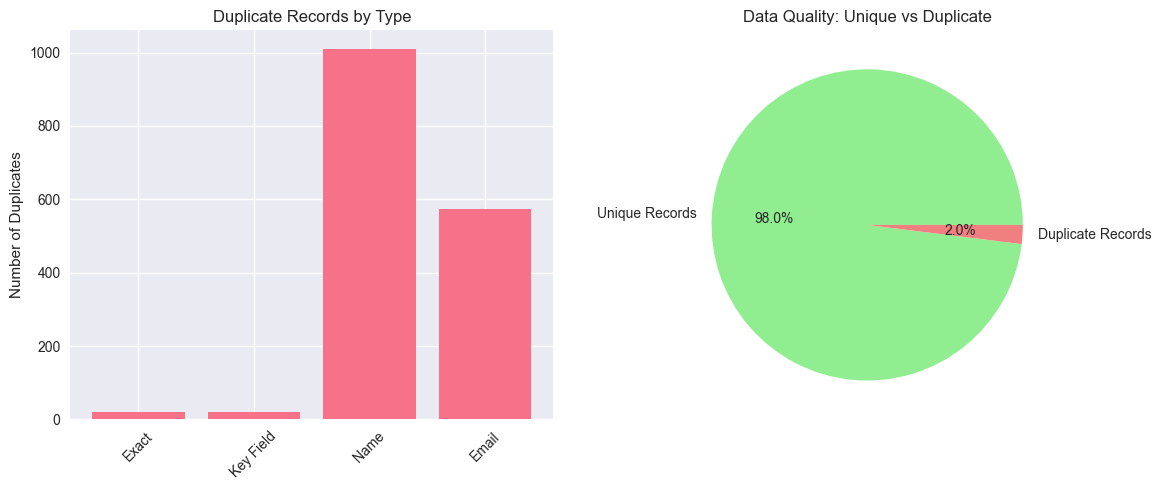


📈 Summary Statistics:
  • Total Records: 1,020
  • Unique Records: 1,000
  • Duplicate Records: 20
  • Data Quality Score: 98.0%

🔄 Duplicate Analysis - Orders
📊 Exact Duplicates: 0 rows (0.00%)

🔑 customer_id Duplicates: 1,914 rows (63.80%)


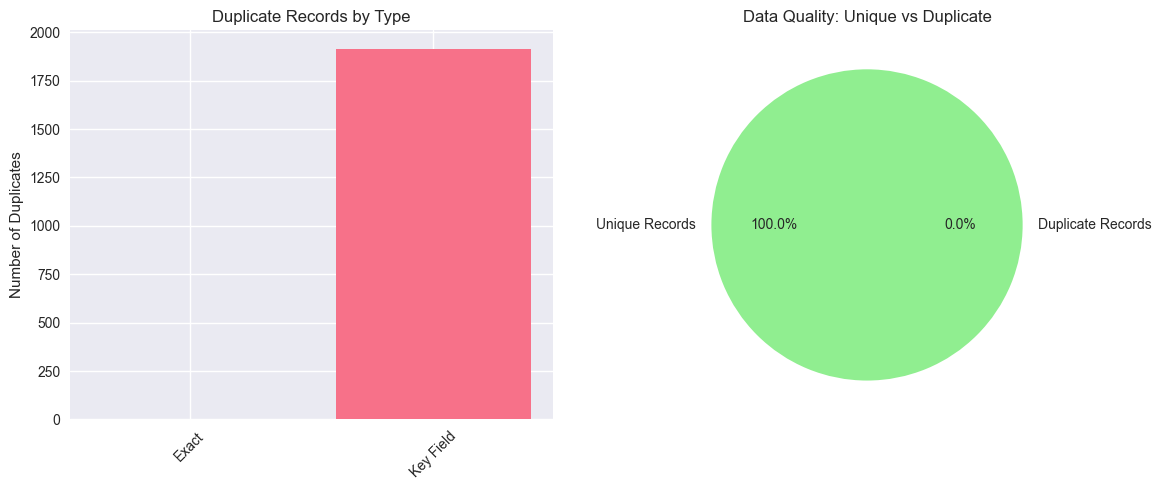


📈 Summary Statistics:
  • Total Records: 3,000
  • Unique Records: 3,000
  • Duplicate Records: 0
  • Data Quality Score: 100.0%


In [5]:
# Comprehensive duplicate analysis
def analyze_duplicates(df, df_name):
    """Detect and analyze various types of duplicates"""
    
    print(f"\n🔄 Duplicate Analysis - {df_name}")
    print("=" * 50)
    
    # 1. Exact duplicates (all columns)
    exact_duplicates = df.duplicated()
    exact_dup_count = exact_duplicates.sum()
    
    print(f"📊 Exact Duplicates: {exact_dup_count:,} rows ({(exact_dup_count/len(df)*100):.2f}%)")
    
    if exact_dup_count > 0:
        print("\n🔍 Sample Exact Duplicates:")
        duplicate_rows = df[df.duplicated(keep=False)].sort_values(df.columns[0])
        print(duplicate_rows.head(10))
    
    # 2. Check duplicates by key columns (business logic)
    if 'customer_id' in df.columns:
        key_col = 'customer_id'
    elif 'order_id' in df.columns:
        key_col = 'order_id'
    else:
        key_col = df.columns[0]
    
    key_duplicates = df.duplicated(subset=[key_col])
    key_dup_count = key_duplicates.sum()
    
    print(f"\n🔑 {key_col} Duplicates: {key_dup_count:,} rows ({(key_dup_count/len(df)*100):.2f}%)")
    
    # 3. Potential duplicates by name/email (for customers)
    if 'name' in df.columns:
        name_duplicates = df.duplicated(subset=['name'], keep=False)
        name_dup_count = name_duplicates.sum()
        print(f"👤 Name Duplicates: {name_dup_count:,} rows ({(name_dup_count/len(df)*100):.2f}%)")
        
        if name_dup_count > 0:
            print("\n🔍 Sample Name Duplicates:")
            name_dup_rows = df[name_duplicates].sort_values('name')
            print(name_dup_rows[['name', 'email', 'customer_id']].head(10))
    
    if 'email' in df.columns:
        email_duplicates = df.duplicated(subset=['email'], keep=False)
        email_dup_count = email_duplicates.sum()
        print(f"📧 Email Duplicates: {email_dup_count:,} rows ({(email_dup_count/len(df)*100):.2f}%)")
    
    # 4. Visualization of duplicates
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Duplicate types comparison
    duplicate_types = ['Exact', 'Key Field', 'Name', 'Email'] if 'name' in df.columns else ['Exact', 'Key Field']
    duplicate_counts = [exact_dup_count, key_dup_count]
    if 'name' in df.columns:
        duplicate_counts.extend([name_dup_count, email_dup_count])
    
    ax1.bar(duplicate_types[:len(duplicate_counts)], duplicate_counts)
    ax1.set_title('Duplicate Records by Type')
    ax1.set_ylabel('Number of Duplicates')
    ax1.tick_params(axis='x', rotation=45)
    
    # Pie chart of data quality
    clean_rows = len(df) - exact_dup_count
    ax2.pie([clean_rows, exact_dup_count], 
            labels=['Unique Records', 'Duplicate Records'],
            autopct='%1.1f%%',
            colors=['lightgreen', 'lightcoral'])
    ax2.set_title('Data Quality: Unique vs Duplicate')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📈 Summary Statistics:")
    print(f"  • Total Records: {len(df):,}")
    print(f"  • Unique Records: {(len(df) - exact_dup_count):,}")
    print(f"  • Duplicate Records: {exact_dup_count:,}")
    print(f"  • Data Quality Score: {((len(df) - exact_dup_count) / len(df) * 100):.1f}%")
    
    return {
        'exact_duplicates': exact_dup_count,
        'key_duplicates': key_dup_count,
        'duplicate_rows': df[exact_duplicates] if exact_dup_count > 0 else pd.DataFrame()
    }

# Analyze duplicates in both datasets
customers_duplicates = analyze_duplicates(customers_df, "Customers")
orders_duplicates = analyze_duplicates(orders_df, "Orders")

## 6. Email Format Validation with Regex

**Email validation** is crucial for:
- Ensuring successful communication with customers
- Maintaining data quality in customer databases
- Preventing bounced emails and poor deliverability
- Compliance with data protection regulations

### 📧 Common Email Format Issues:
- Missing @ symbol
- Missing domain name
- Missing top-level domain
- Invalid characters
- Multiple @ symbols

Let's use regular expressions to validate email formats systematically.

📧 Email Format Validation
📊 Email Validation Results:
  • Total emails: 967
  • Valid emails (basic): 877 (90.7%)
  • Valid emails (strict): 877 (90.7%)
  • Invalid emails: 90 (9.3%)

🚫 Sample Invalid Emails:
  1. anna.jackson@.com
  2. sam.harris@
  3. mark.martin@
  4. sam.moore@
  5. @chris.davis.com
  6. emma.taylor@.com
  7. john.wilson@.com
  8. john.garcia@.com
  9. chris.thomas@
  10. anna.harrisgmail.com

🔍 Invalid Email Categories:
  • Missing @: 24 emails
  • Missing domain: 19 emails
  • Missing TLD: 16 emails
  • Other: 31 emails


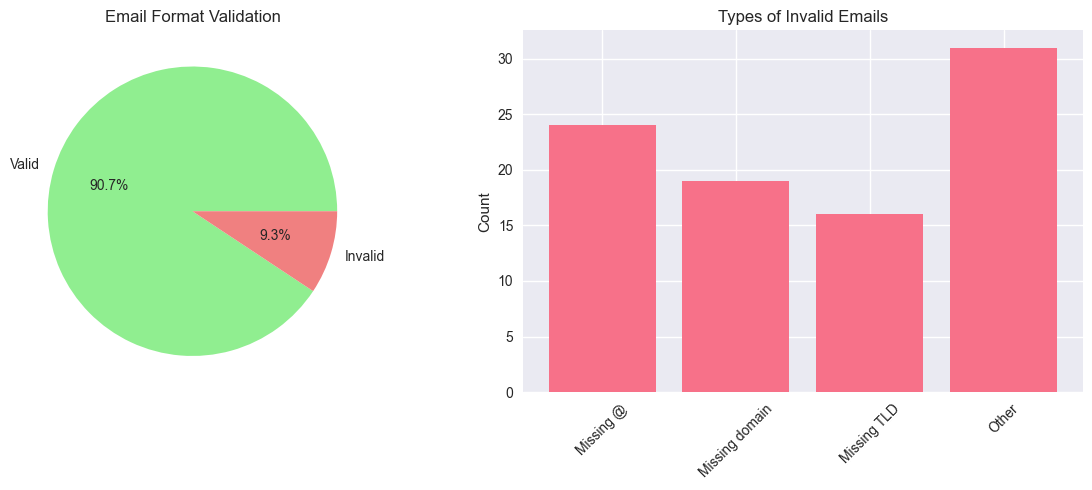


📋 Customers with Invalid Emails:
     customer_id          name                 email
7              8  Anna Jackson     anna.jackson@.com
19            20    Sam Harris           sam.harris@
52            53   Mark Martin          mark.martin@
77            78     Sam Moore            sam.moore@
84            85   Chris Davis      @chris.davis.com
104          105   Emma Taylor      emma.taylor@.com
111          112   John Wilson      john.wilson@.com
118          119   John Garcia      john.garcia@.com
132          133  Chris Thomas         chris.thomas@
143          144   Anna Harris  anna.harrisgmail.com


In [6]:
# Email format validation using regex
def validate_email_formats(df):
    """Comprehensive email validation with detailed analysis"""
    
    print("📧 Email Format Validation")
    print("=" * 40)
    
    # Define email regex pattern (simplified but practical)
    email_pattern = re.compile(
        r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'
    )
    
    # More strict pattern for comparison
    strict_email_pattern = re.compile(
        r'^[a-zA-Z0-9][a-zA-Z0-9._%+-]{0,63}@[a-zA-Z0-9][a-zA-Z0-9.-]{0,62}\.[a-zA-Z]{2,6}$'
    )
    
    if 'email' not in df.columns:
        print("❌ No email column found in dataset")
        return None
    
    # Get non-null emails
    emails = df['email'].dropna()
    total_emails = len(emails)
    
    if total_emails == 0:
        print("❌ No email addresses found")
        return None
    
    # Validate emails
    valid_emails = emails.apply(lambda x: bool(email_pattern.match(str(x))))
    valid_strict = emails.apply(lambda x: bool(strict_email_pattern.match(str(x))))
    
    valid_count = valid_emails.sum()
    valid_strict_count = valid_strict.sum()
    invalid_count = total_emails - valid_count
    
    print(f"📊 Email Validation Results:")
    print(f"  • Total emails: {total_emails:,}")
    print(f"  • Valid emails (basic): {valid_count:,} ({(valid_count/total_emails*100):.1f}%)")
    print(f"  • Valid emails (strict): {valid_strict_count:,} ({(valid_strict_count/total_emails*100):.1f}%)")
    print(f"  • Invalid emails: {invalid_count:,} ({(invalid_count/total_emails*100):.1f}%)")
    
    # Show invalid emails
    invalid_emails = emails[~valid_emails]
    
    if len(invalid_emails) > 0:
        print(f"\n🚫 Sample Invalid Emails:")
        for i, email in enumerate(invalid_emails.head(10)):
            print(f"  {i+1}. {email}")
    
    # Categorize invalid email types
    invalid_categories = {
        'Missing @': 0,
        'Missing domain': 0,
        'Missing TLD': 0,
        'Multiple @': 0,
        'Invalid characters': 0,
        'Other': 0
    }
    
    for email in invalid_emails:
        email_str = str(email)
        if '@' not in email_str:
            invalid_categories['Missing @'] += 1
        elif email_str.count('@') > 1:
            invalid_categories['Multiple @'] += 1
        elif not re.search(r'@.+\..+', email_str):
            if '@' in email_str and '.' not in email_str.split('@')[1]:
                invalid_categories['Missing TLD'] += 1
            else:
                invalid_categories['Missing domain'] += 1
        else:
            invalid_categories['Other'] += 1
    
    print(f"\n🔍 Invalid Email Categories:")
    for category, count in invalid_categories.items():
        if count > 0:
            print(f"  • {category}: {count:,} emails")
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Email validity pie chart
    ax1.pie([valid_count, invalid_count], 
            labels=['Valid', 'Invalid'],
            autopct='%1.1f%%',
            colors=['lightgreen', 'lightcoral'])
    ax1.set_title('Email Format Validation')
    
    # Invalid email categories
    invalid_cats = [cat for cat, count in invalid_categories.items() if count > 0]
    invalid_counts = [count for count in invalid_categories.values() if count > 0]
    
    if invalid_counts:
        ax2.bar(invalid_cats, invalid_counts)
        ax2.set_title('Types of Invalid Emails')
        ax2.set_ylabel('Count')
        ax2.tick_params(axis='x', rotation=45)
    else:
        ax2.text(0.5, 0.5, 'No Invalid Emails', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Types of Invalid Emails')
    
    plt.tight_layout()
    plt.show()
    
    # Add validation flags to dataframe
    df_with_flags = df.copy()
    df_with_flags['email_valid'] = df_with_flags['email'].apply(
        lambda x: bool(email_pattern.match(str(x))) if pd.notna(x) else False
    )
    
    return {
        'total_emails': total_emails,
        'valid_count': valid_count,
        'invalid_count': invalid_count,
        'invalid_emails': invalid_emails,
        'validation_rate': valid_count / total_emails * 100,
        'df_with_flags': df_with_flags
    }

# Validate email formats in customer data
email_validation_results = validate_email_formats(customers_df)

# Show records with invalid emails
if email_validation_results and email_validation_results['invalid_count'] > 0:
    print("\n📋 Customers with Invalid Emails:")
    invalid_email_customers = customers_df[customers_df['email'].isin(email_validation_results['invalid_emails'])]
    print(invalid_email_customers[['customer_id', 'name', 'email']].head(10))

## 7. Outlier Detection in Numerical Fields

**Outliers** can significantly impact:
- Statistical analysis and model performance
- Business metrics and KPIs
- Customer segmentation accuracy
- Revenue and profitability calculations

### 🎯 Outlier Detection Methods:
1. **Statistical Methods**: IQR, Z-score, Modified Z-score
2. **Visualization**: Box plots, scatter plots, histograms
3. **Machine Learning**: Isolation Forest, One-Class SVM

### 🚨 Common Causes of Outliers:
- Data entry errors
- System glitches
- Fraudulent transactions
- Legitimate extreme values (VIP customers)

Let's detect outliers in age, total_spent, and order_value fields.

🔍 Starting Outlier Detection Analysis...


📊 Outlier Detection - age
📈 Basic Statistics for age:
  • Count: 987
  • Mean: 36.48
  • Median: 35.00
  • Std Dev: 20.89
  • Min: -5.00
  • Max: 200.00

🔍 IQR Method:
  • Lower bound: 1.31
  • Upper bound: 68.26
  • Outliers found: 24 (2.4%)

🔍 Z-Score Method (|z| > 3):
  • Outliers found: 12 (1.2%)

🔍 Isolation Forest Method:
  • Outliers found: 99 (10.0%)


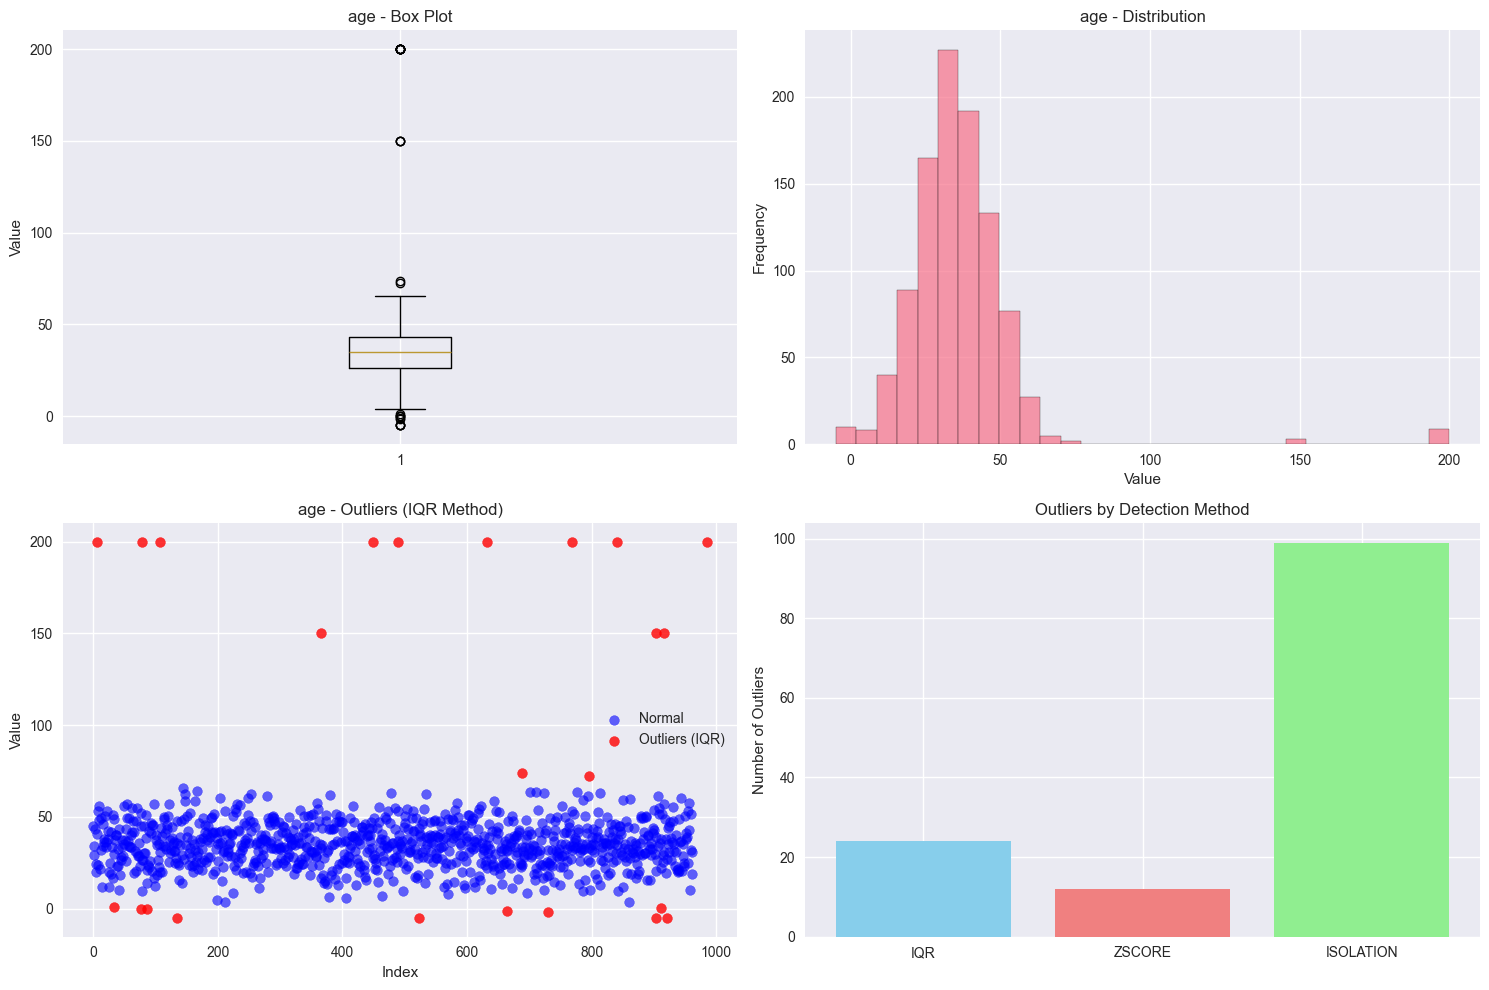


🚨 Sample Outliers (IQR Method):
  1. 200.00
  2. 1.01
  3. 0.00
  4. 200.00
  5. 0.12
  6. 200.00
  7. -5.00
  8. 150.00
  9. 200.00
  10. 200.00

📊 Outlier Detection - total_spent
📈 Basic Statistics for total_spent:
  • Count: 1,020
  • Mean: 704.66
  • Median: 37.94
  • Std Dev: 6936.13
  • Min: 0.00
  • Max: 100000.00

🔍 IQR Method:
  • Lower bound: -169.77
  • Upper bound: 305.64
  • Outliers found: 112 (11.0%)

🔍 Z-Score Method (|z| > 3):
  • Outliers found: 7 (0.7%)

🔍 Isolation Forest Method:
  • Outliers found: 102 (10.0%)


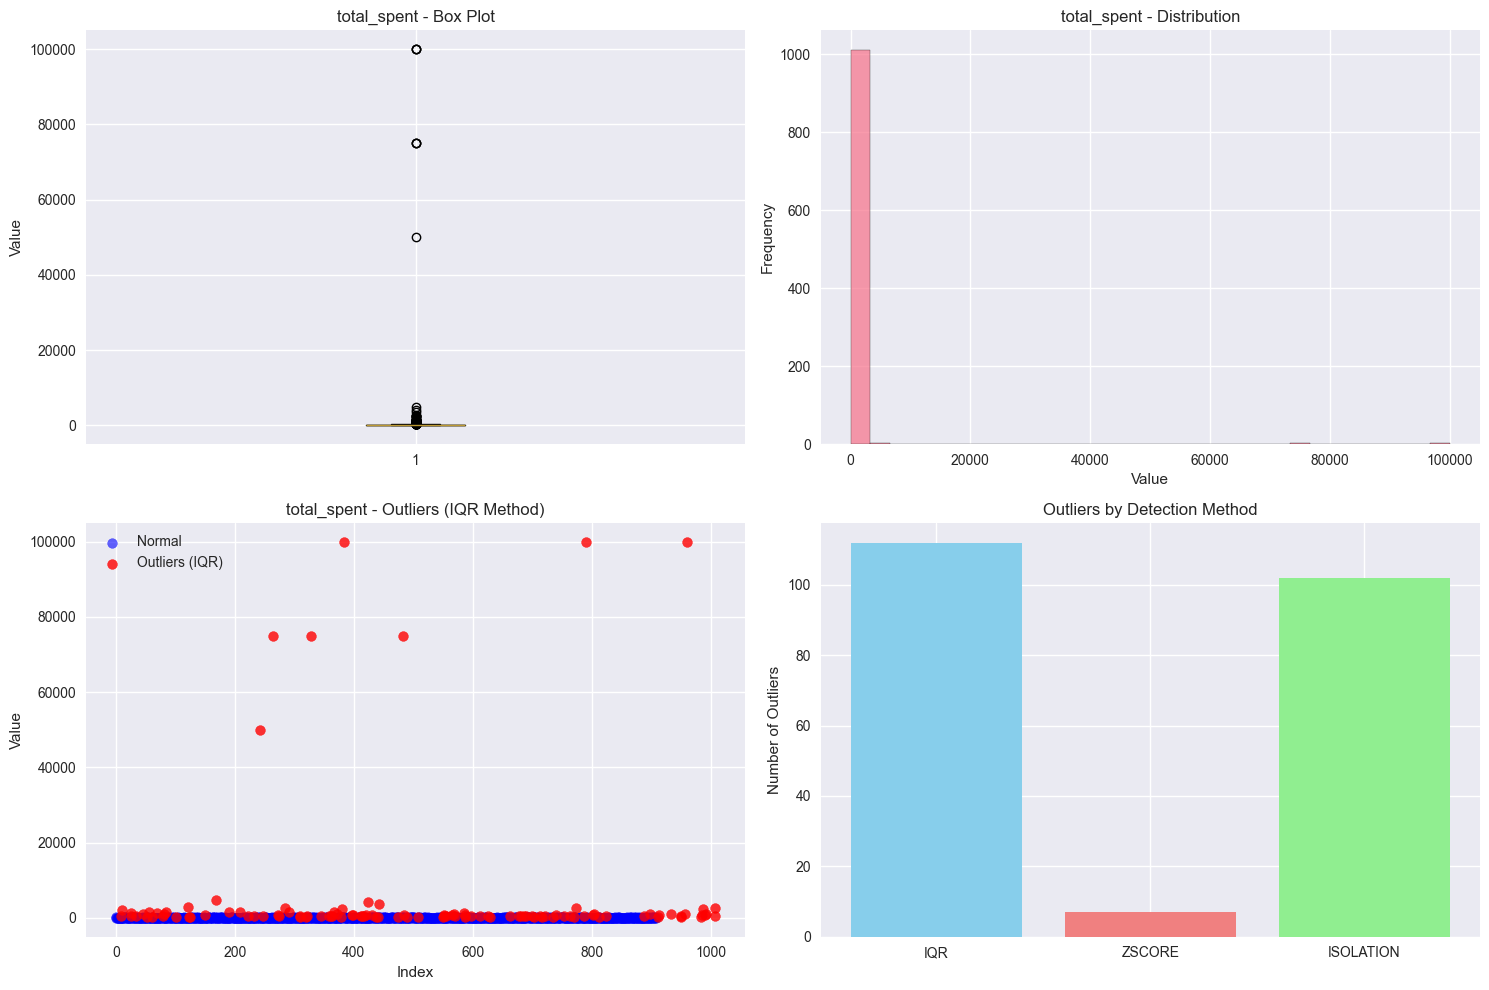


🚨 Sample Outliers (IQR Method):
  1. 420.00
  2. 2055.28
  3. 414.91
  4. 1272.97
  5. 599.50
  6. 928.82
  7. 334.90
  8. 1502.35
  9. 371.22
  10. 1314.87

📊 Outlier Detection - order_value
📈 Basic Statistics for order_value:
  • Count: 3,000
  • Mean: 358.71
  • Median: 20.69
  • Std Dev: 2329.36
  • Min: 0.82
  • Max: 20000.00

🔍 IQR Method:
  • Lower bound: -37.77
  • Upper bound: 89.96
  • Outliers found: 241 (8.0%)

🔍 Z-Score Method (|z| > 3):
  • Outliers found: 61 (2.0%)

🔍 Isolation Forest Method:
  • Outliers found: 300 (10.0%)


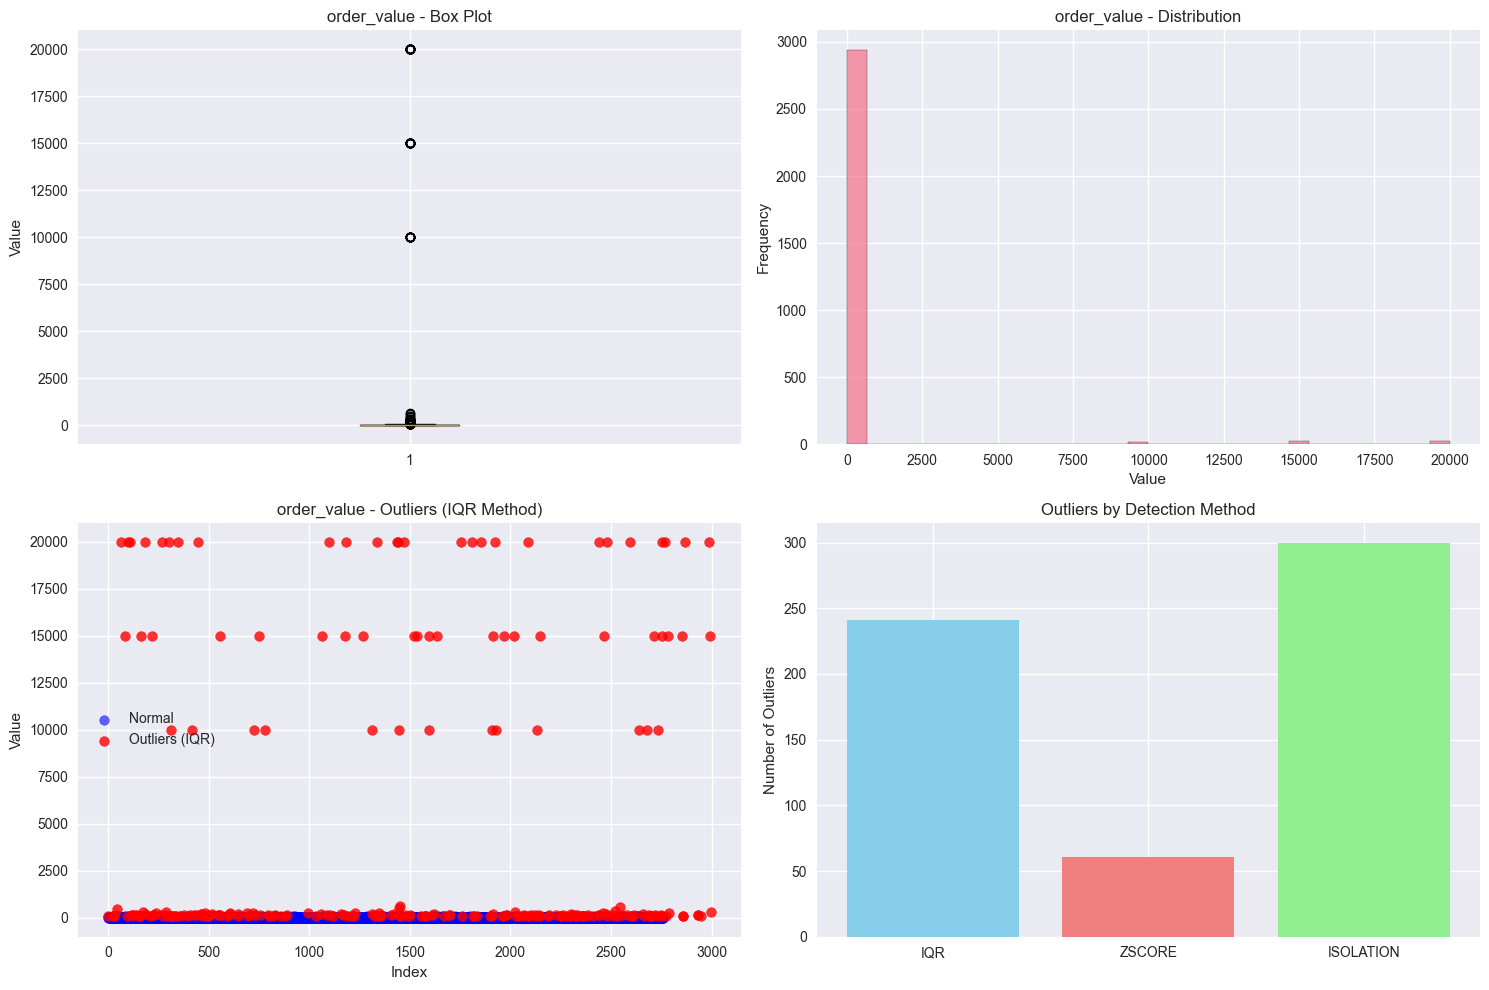


🚨 Sample Outliers (IQR Method):
  1. 95.75
  2. 127.57
  3. 119.03
  4. 153.99
  5. 460.13
  6. 20000.00
  7. 15000.00
  8. 101.04
  9. 20000.00
  10. 20000.00


In [7]:
# Comprehensive outlier detection
from sklearn.ensemble import IsolationForest
from scipy import stats

def detect_outliers(df, column, methods=['iqr', 'zscore', 'isolation']):
    """Detect outliers using multiple methods"""
    
    print(f"\n📊 Outlier Detection - {column}")
    print("=" * 50)
    
    # Get non-null numeric values
    values = df[column].dropna()
    
    if len(values) == 0:
        print(f"❌ No valid values found in {column}")
        return None
    
    print(f"📈 Basic Statistics for {column}:")
    print(f"  • Count: {len(values):,}")
    print(f"  • Mean: {values.mean():.2f}")
    print(f"  • Median: {values.median():.2f}")
    print(f"  • Std Dev: {values.std():.2f}")
    print(f"  • Min: {values.min():.2f}")
    print(f"  • Max: {values.max():.2f}")
    
    outliers_results = {}
    
    # Method 1: IQR (Interquartile Range)
    if 'iqr' in methods:
        Q1 = values.quantile(0.25)
        Q3 = values.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        iqr_outliers = values[(values < lower_bound) | (values > upper_bound)]
        outliers_results['iqr'] = {
            'count': len(iqr_outliers),
            'percentage': len(iqr_outliers) / len(values) * 100,
            'outliers': iqr_outliers,
            'bounds': (lower_bound, upper_bound)
        }
        
        print(f"\n🔍 IQR Method:")
        print(f"  • Lower bound: {lower_bound:.2f}")
        print(f"  • Upper bound: {upper_bound:.2f}")
        print(f"  • Outliers found: {len(iqr_outliers):,} ({len(iqr_outliers)/len(values)*100:.1f}%)")
    
    # Method 2: Z-Score
    if 'zscore' in methods:
        z_scores = np.abs(stats.zscore(values))
        zscore_outliers = values[z_scores > 3]  # |z| > 3
        
        outliers_results['zscore'] = {
            'count': len(zscore_outliers),
            'percentage': len(zscore_outliers) / len(values) * 100,
            'outliers': zscore_outliers,
            'threshold': 3
        }
        
        print(f"\n🔍 Z-Score Method (|z| > 3):")
        print(f"  • Outliers found: {len(zscore_outliers):,} ({len(zscore_outliers)/len(values)*100:.1f}%)")
    
    # Method 3: Isolation Forest (Machine Learning)
    if 'isolation' in methods and len(values) > 10:
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        outlier_labels = iso_forest.fit_predict(values.values.reshape(-1, 1))
        isolation_outliers = values[outlier_labels == -1]
        
        outliers_results['isolation'] = {
            'count': len(isolation_outliers),
            'percentage': len(isolation_outliers) / len(values) * 100,
            'outliers': isolation_outliers
        }
        
        print(f"\n🔍 Isolation Forest Method:")
        print(f"  • Outliers found: {len(isolation_outliers):,} ({len(isolation_outliers)/len(values)*100:.1f}%)")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Box plot
    axes[0, 0].boxplot(values, vert=True)
    axes[0, 0].set_title(f'{column} - Box Plot')
    axes[0, 0].set_ylabel('Value')
    
    # 2. Histogram
    axes[0, 1].hist(values, bins=30, edgecolor='black', alpha=0.7)
    axes[0, 1].set_title(f'{column} - Distribution')
    axes[0, 1].set_xlabel('Value')
    axes[0, 1].set_ylabel('Frequency')
    
    # 3. Scatter plot with outliers highlighted (IQR method)
    if 'iqr' in outliers_results:
        normal_values = values[~values.isin(outliers_results['iqr']['outliers'])]
        axes[1, 0].scatter(range(len(normal_values)), normal_values, 
                          alpha=0.6, label='Normal', color='blue')
        if len(outliers_results['iqr']['outliers']) > 0:
            outlier_indices = [i for i, v in enumerate(values) if v in outliers_results['iqr']['outliers'].values]
            axes[1, 0].scatter(outlier_indices, outliers_results['iqr']['outliers'], 
                              alpha=0.8, label='Outliers (IQR)', color='red', s=50)
        axes[1, 0].set_title(f'{column} - Outliers (IQR Method)')
        axes[1, 0].set_xlabel('Index')
        axes[1, 0].set_ylabel('Value')
        axes[1, 0].legend()
    
    # 4. Comparison of methods
    method_names = []
    outlier_counts = []
    for method, results in outliers_results.items():
        method_names.append(method.upper())
        outlier_counts.append(results['count'])
    
    if method_names:
        axes[1, 1].bar(method_names, outlier_counts, color=['skyblue', 'lightcoral', 'lightgreen'][:len(method_names)])
        axes[1, 1].set_title('Outliers by Detection Method')
        axes[1, 1].set_ylabel('Number of Outliers')
    
    plt.tight_layout()
    plt.show()
    
    # Show sample outliers
    if 'iqr' in outliers_results and len(outliers_results['iqr']['outliers']) > 0:
        print(f"\n🚨 Sample Outliers (IQR Method):")
        sample_outliers = outliers_results['iqr']['outliers'].head(10)
        for i, value in enumerate(sample_outliers):
            print(f"  {i+1}. {value:.2f}")
    
    return outliers_results

# Analyze outliers in key numerical columns
print("🔍 Starting Outlier Detection Analysis...\n")

# Age outliers
age_outliers = detect_outliers(customers_df, 'age')

# Total spent outliers
spent_outliers = detect_outliers(customers_df, 'total_spent')

# Order value outliers
order_outliers = detect_outliers(orders_df, 'order_value')